In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline
from datetime import datetime, timedelta
from scipy import stats
from matplotlib.lines import Line2D
import geopandas

import glob

import sys
sys.path.append('../')
import plotting
import utils

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

# Data

In [2]:
ds1 = xr.open_dataset('./final_data/ds_NOX_SO2_CH2O_daily.nc4')
ds2 = xr.open_dataset('./final_data/ds_PM_O3_daily.nc4')

ds = ds1.merge(ds2)
#molecular weights of species
mw_species = {
    'NH4': 18.,
    'NIT': 62.,
    'SO4': 96.,
    'BCPI': 12.,
    'OCPI': 12.,
    'BCPO': 12.,
    'OCPO': 12.,
    'DST1': 29.,
    'DST2': 29.,
    'SALA': 31.4,
}


### Import Dataframes of Interpolated and EPA Data

In [3]:
interp_EPA_df = pd.read_csv('./final_data/interp_EPA_df.csv', parse_dates = True)
EPA_obs_df = pd.read_csv('./final_data/EPA_obs_df.csv', parse_dates = True)
EPA_monthly_df = pd.read_csv('./final_data/EPA_monthly_obs_df.csv', parse_dates = True)
interp_EPA_df = interp_EPA_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

IMPROVE_obs_df = pd.read_csv('./final_data/IMPROVE_df.csv', parse_dates = True)
interp_IMPROVE_df = pd.read_csv('./final_data/interp_IMPROVE_df.csv', parse_dates = True)
IMPROVE_monthly_df = pd.read_csv('./final_data/IMPROVE_monthly_obs_df.csv', parse_dates = True)
interp_IMPROVE_df = interp_IMPROVE_df.rename(columns = {'Latitude':'latitude','Longitude':'longitude'})

#change to datetime
interp_EPA_df['date'] = pd.to_datetime(interp_EPA_df['date'])
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['date'], format='%Y%m%d')
EPA_monthly_df['date'] = pd.to_datetime(EPA_monthly_df['date'], format = '%Y%m%d')
IMPROVE_obs_df['date'] = pd.to_datetime(IMPROVE_obs_df['date'], format = '%Y%m%d')
interp_IMPROVE_df['date'] = pd.to_datetime(interp_IMPROVE_df['date'])
IMPROVE_monthly_df['date'] = pd.to_datetime(IMPROVE_monthly_df['date'], format = '%Y%m%d')

#select only Lat and Lon on continental US
EPA_obs_df = EPA_obs_df.loc[(EPA_obs_df['Latitude'].between(24,50,"both")) & (EPA_obs_df['Longitude'].between(-130,-60,"both"))]
EPA_monthly_df = EPA_monthly_df.loc[(EPA_monthly_df['Latitude'].between(24,50,"both")) & (EPA_monthly_df['Longitude'].between(-130,-60,"both"))]
interp_EPA_df = interp_EPA_df.loc[(interp_EPA_df['latitude'].between(24,50,"both")) & (interp_EPA_df['longitude'].between(-130,-60,"both"))]
IMPROVE_obs_df = IMPROVE_obs_df.loc[(IMPROVE_obs_df['Latitude'].between(24,50,"both")) & (IMPROVE_obs_df['Longitude'].between(-130,-60,"both"))]
interp_IMPROVE_df = interp_IMPROVE_df.loc[(interp_IMPROVE_df['latitude'].between(24,50,"both")) & (interp_IMPROVE_df['longitude'].between(-130,-60,"both"))]
IMPROVE_monthly_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Latitude'].between(24,50,"both")) & (IMPROVE_monthly_df['Longitude'].between(-130,-60,"both"))]

#change latitude
interp_IMPROVE_df = interp_IMPROVE_df.rename(columns = {'latitude':'Latitude','longitude':'Longitude'})
interp_EPA_df = interp_EPA_df.rename(columns = {'latitude':'Latitude','longitude':'Longitude'})

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Lists/Dicts of Variables

In [4]:
#define Lat and Lon of the nested grid US
model_names = ['egrid_NA','nei_NA', 'normal_NA', 'epa_NA']

levels_dict = {'PM25':np.arange(0., 51, 1), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}
colors_dict = {'egrid_NA':'xkcd:scarlet', 'epa_NA':'xkcd:bluish','normal_NA':'xkcd:forest green', 'nei_NA':'xkcd:orange'}

### Dictionary of Differences between Interpolation and Observations

In [5]:
EPA_interp_dif = utils.interp_obs_differences(EPA_obs_df, interp_EPA_df, utils.month_string, model_names,['PM25', 'SO2', 'NO2', 'O3'])
IMPROVE_interp_dif = utils.interp_obs_differences(IMPROVE_obs_df, interp_IMPROVE_df, utils.month_string, model_names, ['NIT','SO4','PM25'])

# Plots 

In [6]:
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_string = utils.month_string
cmap_conc = 'pink_r'
cmap_dif = 'BrBG_r'


### Differences between Observations and GC Run

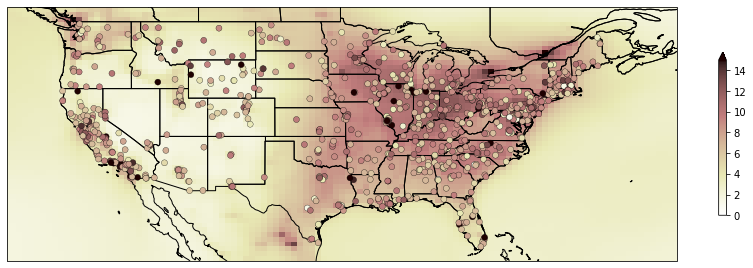

In [7]:
fig = plt.figure(figsize = (15,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeat.STATES)
cmap = cmap_conc
vmin = 0
vmax = 15
months = [12,1,2]#[6,7,8] #
pollutant = 'PM25'
####### GEOS-CHEM output #######
#PCM parameters and plot for model
PCM_m=ax.pcolormesh(ds.sel(model_name = 'normal_NA').groupby('time.month').mean().sel(month = months)['lon'], 
                    ds.sel(model_name = 'normal_NA').groupby('time.month').mean().sel(month = months)['lat'], 
                    ds.sel(model_name = 'normal_NA').groupby('time.month').mean().sel(month = months).mean(dim = 'month')[pollutant],
                    cmap=cmap,
                    vmin=vmin, 
                    vmax=vmax, 
                    zorder = 1)

###### observations #######
#create lat and lon for observations
lat_o = EPA_obs_df.loc[(EPA_obs_df['species'] == pollutant) & (EPA_obs_df.date.dt.month.isin(months))]['Latitude'].unique()
lon_o = EPA_obs_df.loc[(EPA_obs_df['species'] == pollutant) & (EPA_obs_df.date.dt.month.isin(months))]['Longitude'].unique()
#define the concentrations for observations
mean_conc=EPA_obs_df.loc[(EPA_obs_df['species'] == pollutant) & (EPA_obs_df.date.dt.month.isin(months))].groupby(['Latitude','Longitude']).mean()['Arithmetic Mean']
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c=mean_conc, transform=ccrs.PlateCarree(),cmap=cmap,edgecolors='k',linewidth=.3,vmin=vmin, vmax=vmax, zorder = 2)
plt.colorbar(PCM_o, ax=ax,extend='max', shrink=.3) 

###### adjustments and labels ########
#adjust lat&lon being mapped
ax.set_extent(utils.lat_lon_dict['US_lat_lon'])
#plt.savefig(f'{months}_{pollutant}_obs_comparison.png', dpi = 150, bbox_inches = 'tight'); #title

/tmp/ipykernel_1908227/1741377820.py:9: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(PCM_o, ax=ax,extend='both', cmap = cmap_dif)


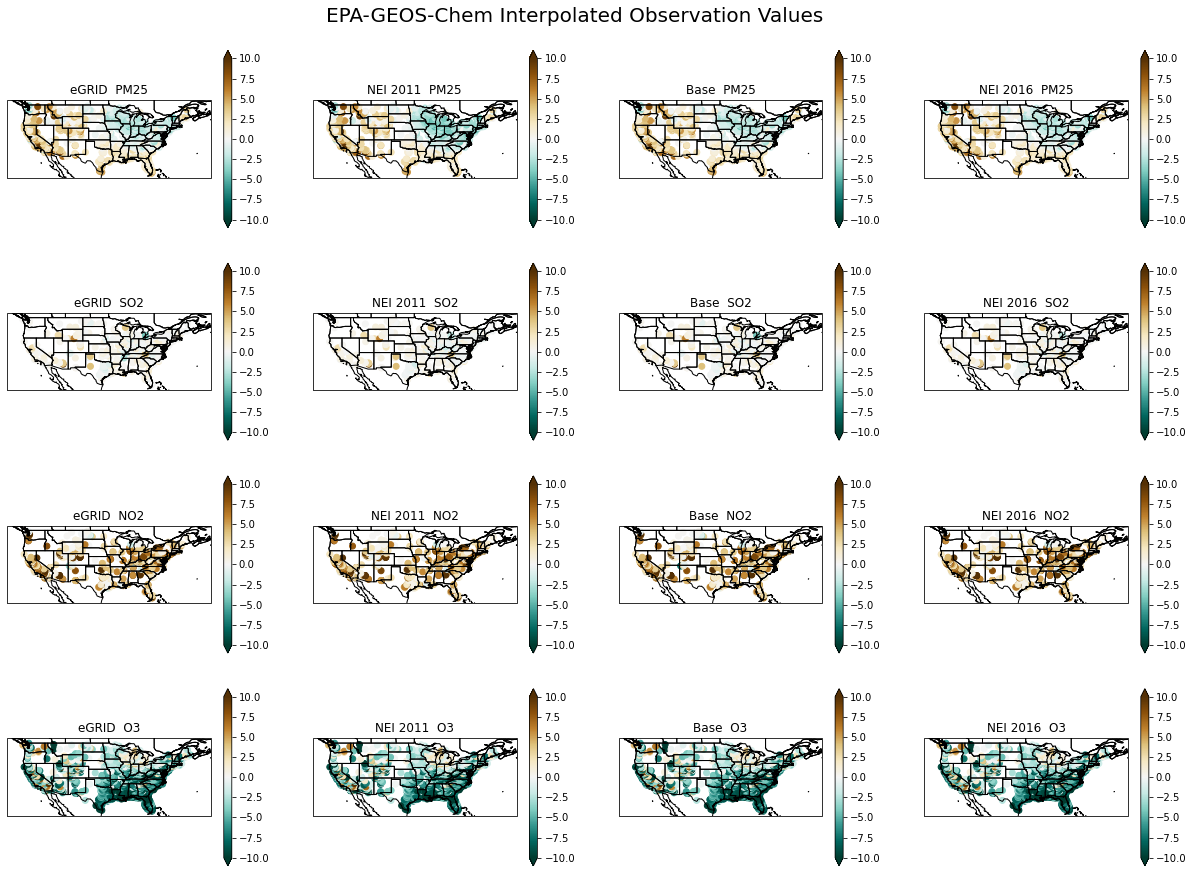

In [8]:
fig, axes = plt.subplots(4,4,figsize = [21,15],subplot_kw={'projection': ccrs.PlateCarree()})
for idx_s, species in enumerate(['PM25', 'SO2', 'NO2', 'O3']):
    for idx_m, model in enumerate(model_names):
        ax = axes[idx_s,idx_m] 
        lat_o = EPA_interp_dif[species][model].reset_index()['Latitude']
        lon_o = EPA_interp_dif[species][model].reset_index()['Longitude']
        c = EPA_interp_dif[species][model].reset_index()['Arithmetic Mean']
        PCM_o = ax.scatter(lon_o, lat_o, c = c, transform = ccrs.PlateCarree(), cmap = cmap_dif, vmin = -10, vmax = 10)
        plt.colorbar(PCM_o, ax=ax,extend='both', cmap = cmap_dif) 
        ax.coastlines()
        ax.add_feature(cfeat.STATES)
        ax.set_extent(utils.lat_lon_dict['US_lat_lon'])
        ax.set_title(f'{plotting.proper_model_names_dict[model]}  {species}')
plt.suptitle('EPA-GEOS-Chem Interpolated Observation Values', fontsize = 20, y = .92);

# Linear Regression and Scatterplots

## Scatterplots of interpolation

In [8]:
### linear regression on our data (EPA vs GC model runs)
lin_regress_EPA_df = utils.linregress_data(EPA_obs_df, interp_EPA_df, model_names, month_string, ['PM25', 'SO2', 'NO2', 'O3'])
lin_regress_IMPROVE_df = utils.linregress_data(IMPROVE_obs_df, interp_IMPROVE_df, model_names, month_string, ['NIT','PM25','SO4'])

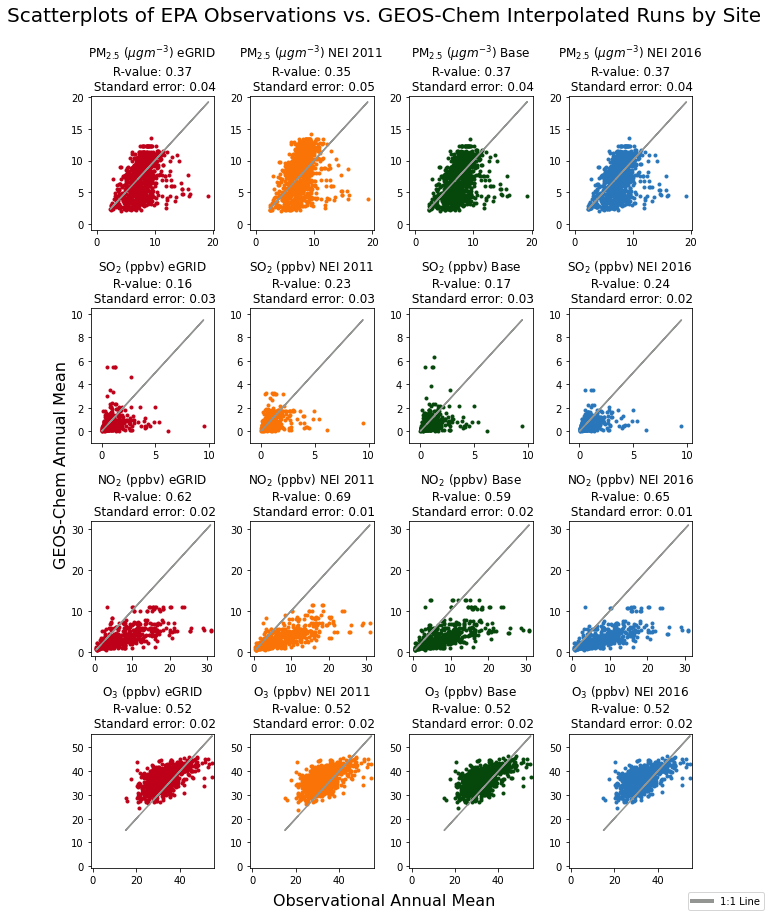

In [19]:
plotting.interp_scatterplot(interp_EPA_df, EPA_obs_df, lin_regress_EPA_df, ['PM25', 'SO2', 'NO2', 'O3'], 
                            model_names = model_names, month_string = month_string, colors_dict = colors_dict,
                           rows = 4, columns = 4)
plt.suptitle('Scatterplots of EPA Observations vs. GEOS-Chem Interpolated Runs by Site', fontsize = 20, y = 1.03);
plt.savefig('./Figures/supplement/EPA_obs_comp.png', dpi = 350, bbox_inches = 'tight')


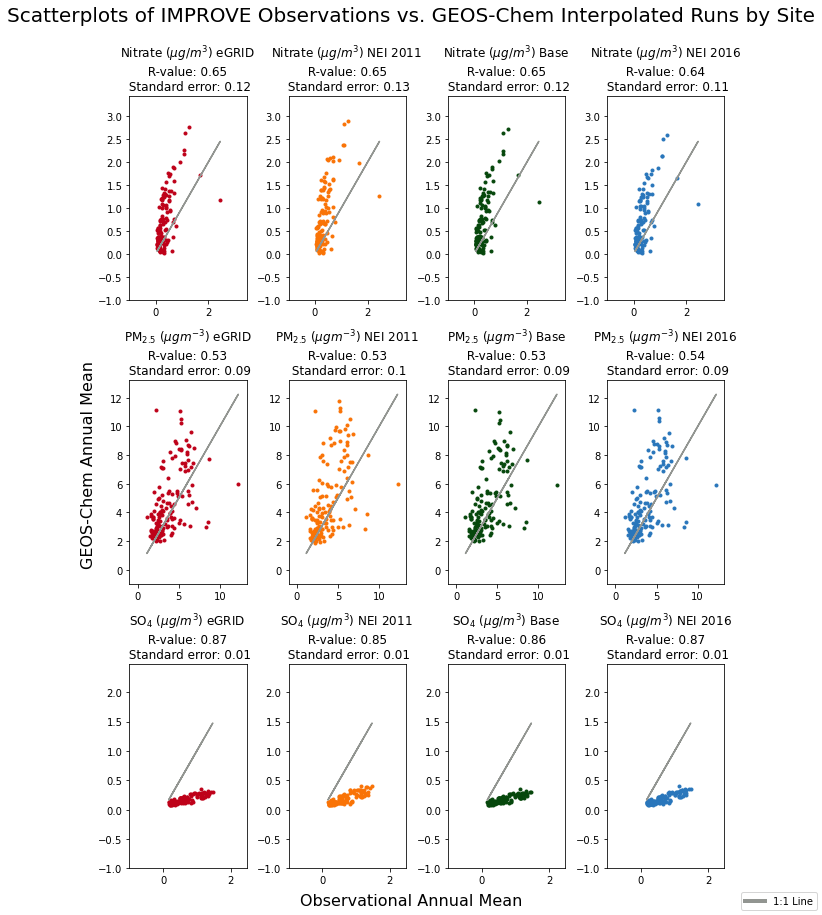

In [18]:
plotting.interp_scatterplot(interp_IMPROVE_df, IMPROVE_obs_df, lin_regress_IMPROVE_df, 
                            ['NIT','PM25','SO4'], model_names = model_names, month_string = month_string, colors_dict = colors_dict,
                           rows = 3, columns = 4)
plt.suptitle('Scatterplots of IMPROVE Observations vs. GEOS-Chem Interpolated Runs by Site', fontsize = 20, y = 1.03);
plt.savefig('./Figures/supplement/IMPROVE_obs_comp.png', dpi = 350, bbox_inches = 'tight')


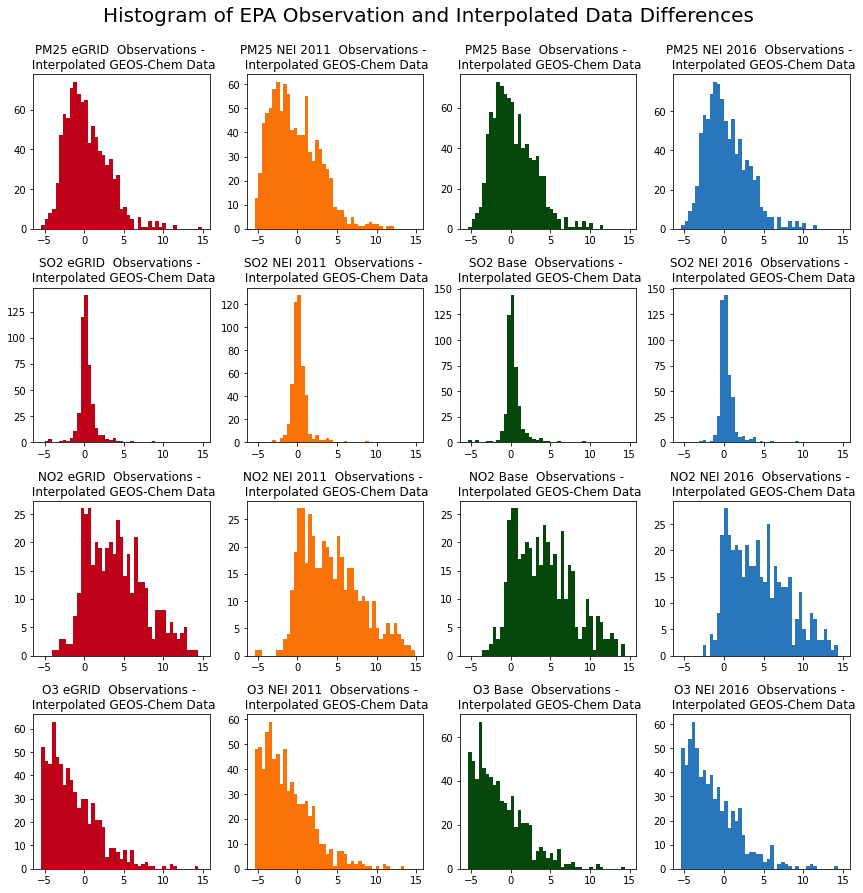

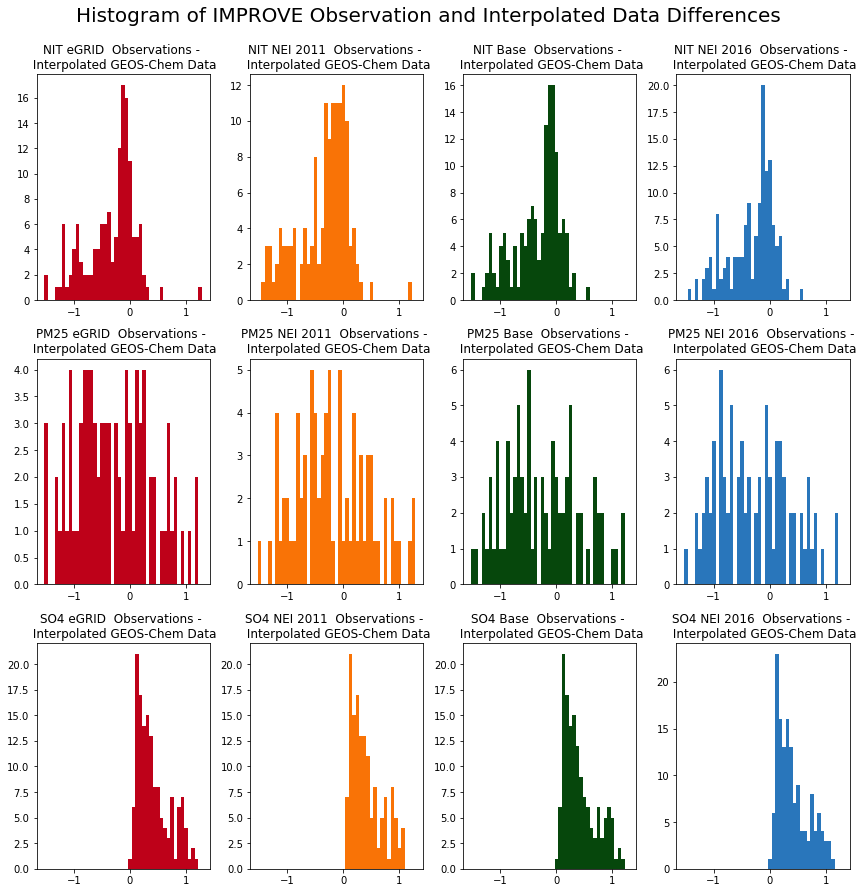

In [11]:
plotting.hist_obs_interp(EPA_interp_dif, model_names, colors_dict, bins = 45, species_list = ['PM25', 'SO2', 'NO2', 'O3'], rows = 4, columns = 4)
plt.suptitle('Histogram of EPA Observation and Interpolated Data Differences', fontsize = 20, y = 1.03);

plotting.hist_obs_interp(IMPROVE_interp_dif, model_names, colors_dict, bins = 45, species_list = ['NIT','PM25','SO4'], rows = 3, columns = 4)
plt.suptitle('Histogram of IMPROVE Observation and Interpolated Data Differences', fontsize = 20, y = 1.03);

## Group Dataframes by region and look at regional distribution of error

#### Merge Datasets

In [14]:
### merge datasets into one with region, model, species as the categories
EPA_monthly_df['model_name'] = 'EPA'
IMPROVE_monthly_df['model_name'] = 'IMPROVE'
cdf = pd.concat([EPA_monthly_df, interp_EPA_df,interp_IMPROVE_df, IMPROVE_monthly_df])   # CONCATENATE
mdf = pd.melt(cdf, id_vars=['Region','model_name','species'],value_vars = ['Arithmetic Mean'])      # MELT

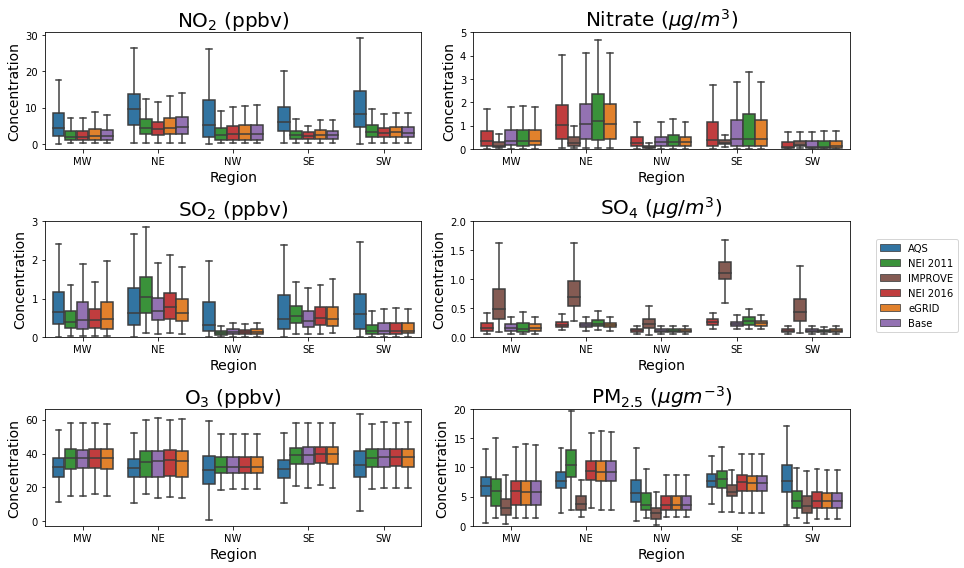

In [17]:
#create list of colors for palette
unique = mdf["model_name"].unique()
palette = dict(zip(unique, sns.color_palette()))

#create list of proper names for regions
region_name = ['MW','SW','NW','NE','SE']
region_dict = dict(zip(['MW_lat_lon', 'SW_lat_lon', 'NW_lat_lon', 'NE_lat_lon',
       'SE_lat_lon'],region_name))

#plot 
fig = plt.figure(figsize = [12,8])

for idx, species in enumerate(['NO2','NIT','SO2','SO4','O3','PM25']):
    ax = fig.add_subplot(3, 2, idx+1)
    q = sns.boxplot(y='value', x='Region', hue = 'model_name',
                     data=mdf.loc[(mdf['species'] == species)].sort_values('Region'), 
                     width=0.8,
                     palette=palette,
                     showfliers = False)
    plt.title(f'{plotting.proper_names_dict[species]}', fontsize = 20);
    #adjust ylim for different species
    if species == 'SO2':
        plt.ylim([0,3])
    if species == 'PM25':
        plt.ylim([0,20])
    if species == 'SO4':
        plt.ylim([0,2])
    if species == 'NIT':
        plt.ylim([0,5])
    ax.get_legend().set_visible(False)
    fig.tight_layout()
    #adjust title and fontsize of x and y labels
    ax.set_ylabel('Concentration', fontsize = 14)
    ax.set_xlabel('Region', fontsize = 14)
    #change labels to proper region names
    texts = [t.get_text()  for t in ax.get_xticklabels()]
    ax.set_xticklabels([region_dict[region] for region in texts])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, [plotting.proper_model_names_dict[label] for label in labels], bbox_to_anchor=(1.3, 2.5), bbox_transform=ax.transAxes);
plt.savefig('./Figures/supplement/obs_boxplots.png', bbox_inches = 'tight', dpi = 350)

## calculate NMB

In [17]:
#find where the NIT data and PM data diverge and get rid of these readings in the PM data
PM_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'PM25')]
NIT_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'NIT')]
comparison_df = NIT_df.merge(PM_df,
                              indicator=True,
                              how='outer', on = ['geometry','date'])
PM_to_delete = comparison_df[comparison_df['_merge'] == 'right_only'].dropna(axis = 1)
PM_to_delete = PM_to_delete.rename(columns = {'Arithmetic Mean_y':'Arithmetic Mean', 'Latitude_y':'Latitude', 'Longitude_y':'Longitude','species_y':'species','Region_y':'Region','annual_T_y':'annual_T','annual_RH_y':'annual_RH','model_y':'model'})
PM_to_delete = PM_to_delete.drop(columns = '_merge')

#drop these values from the cdf
cdf = pd.concat([comparison_df, PM_to_delete]).drop_duplicates(keep=False)

In [18]:
#merge our IMPROVE data
IMPROVE_merged_df = IMPROVE_monthly_df.merge(interp_IMPROVE_df,
                              indicator=True,
                              how='inner', on = ['species','date','Latitude','Longitude', 'Region'])


In [19]:
#rename our columns
IMPROVE_merged_df = IMPROVE_merged_df.rename(columns = {'Arithmetic Mean_x': 'Observational mean', 'model_name_x':'observation', 
                                    'Arithmetic Mean_y':'Model mean', 'model_name_y':'model'})

In [20]:
#drop rows where observations are not taken (nans)
IMPROVE_merged_df.dropna(axis = 0)

#merge our IMPROVE data
EPA_merged_df = EPA_monthly_df.merge(interp_EPA_df,
                              indicator=True,
                              how='inner', on = ['Latitude','Longitude','species','Region','date'])
EPA_merged_df = EPA_merged_df.rename(columns = {'Arithmetic Mean_x': 'Observational mean', 'model_name_x':'observation', 
                                    'Arithmetic Mean_y':'Model mean', 'model_name_y':'model'})
EPA_merged_df = EPA_merged_df.dropna(axis = 0)

#calculate the difference between model and observations
EPA_merged_df['model-obs'] = EPA_merged_df['Model mean'] - EPA_merged_df['Observational mean']
IMPROVE_merged_df['model-obs'] = IMPROVE_merged_df['Model mean'] - IMPROVE_merged_df['Observational mean']

In [21]:
#make a dataframe of our normalized mean bias data by region and season and species, just for the MODEL runs
season_dict = {'DJF':[12,1,2],'JJA':[6,7,8]}
NMB_df = pd.DataFrame()
for region in IMPROVE_merged_df['Region'].unique():
    for species in IMPROVE_merged_df['species'].unique():
        for season in season_dict.keys():
            NMB = IMPROVE_merged_df.loc[(IMPROVE_merged_df['Region'] == region) & 
                                  (IMPROVE_merged_df['species'] == species) & 
                                  (IMPROVE_merged_df['model'] == 'normal_NA') &
                                 (IMPROVE_merged_df['date'].dt.month.isin(season_dict[season]))]['model-obs'].sum()/IMPROVE_merged_df.loc[(IMPROVE_merged_df['Region'] == region) & 
                                  (IMPROVE_merged_df['species'] == species) & 
                                  (IMPROVE_merged_df['model'] == 'normal_NA')& 
                                (IMPROVE_merged_df['date'].dt.month.isin(season_dict[season]))]['Observational mean'].sum()*100
            tmp_df = pd.DataFrame({'model_name':'MODEL','observations':'IMPROVE','season':season, 'region': region, 'species':species,'NMB':NMB}, index = np.arange(1))
            NMB_df = NMB_df.append(tmp_df, sort =False, ignore_index = True)
    for species in EPA_merged_df['species'].unique():
        for season in season_dict.keys():
            NMB = EPA_merged_df.loc[(EPA_merged_df['Region'] == region) & 
                                  (EPA_merged_df['species'] == species) & 
                                  (EPA_merged_df['model'] == 'normal_NA') &
                                 (EPA_merged_df['date'].dt.month.isin(season_dict[season]))]['model-obs'].sum()/EPA_merged_df.loc[(EPA_merged_df['Region'] == region) & 
                                  (EPA_merged_df['species'] == species) & 
                                  (EPA_merged_df['model'] == 'normal_NA')& 
                                (EPA_merged_df['date'].dt.month.isin(season_dict[season]))]['Observational mean'].sum()*100
            tmp_df = pd.DataFrame({'model':'normal_NA','observations':'EPA','season':season, 'region': region, 'species':species,'NMB':NMB}, index = np.arange(1))
            NMB_df = NMB_df.append(tmp_df, sort =False, ignore_index = True)

In [80]:
NMB_df.loc[NMB_df['species'] == 'O3']

,model_name,observations,season,region,species,NMB,model
10,NaN,EPA,DJF,MW_lat_lon,O3,0.526523,normal_NA
11,NaN,EPA,JJA,MW_lat_lon,O3,33.980871,normal_NA
24,NaN,EPA,DJF,SW_lat_lon,O3,27.420457,normal_NA
25,NaN,EPA,JJA,SW_lat_lon,O3,9.320697,normal_NA
38,NaN,EPA,DJF,NW_lat_lon,O3,16.286352,normal_NA
39,NaN,EPA,JJA,NW_lat_lon,O3,11.244570,normal_NA
52,NaN,EPA,DJF,NE_lat_lon,O3,-7.646880,normal_NA
53,NaN,EPA,JJA,NE_lat_lon,O3,33.898975,normal_NA
66,NaN,EPA,DJF,SE_lat_lon,O3,18.992664,normal_NA
67,NaN,EPA,JJA,SE_lat_lon,O3,58.227582,normal_NA


In [31]:
NMB_df.loc[NMB_df['species'] == 'PM25'].loc[NMB_df['model'] == 'normal_NA']

,model_name,observations,season,region,species,NMB,model
16,NaN,EPA,DJF,MW_lat_lon,PM25,11.392657,normal_model
17,NaN,EPA,JJA,MW_lat_lon,PM25,-7.449948,normal_model
36,NaN,EPA,DJF,SW_lat_lon,PM25,-37.256766,normal_model
37,NaN,EPA,JJA,SW_lat_lon,PM25,-31.256513,normal_model
56,NaN,EPA,DJF,NW_lat_lon,PM25,-42.088723,normal_model
57,NaN,EPA,JJA,NW_lat_lon,PM25,-12.024655,normal_model
76,NaN,EPA,DJF,NE_lat_lon,PM25,41.258720,normal_model
77,NaN,EPA,JJA,NE_lat_lon,PM25,13.203626,normal_model
96,NaN,EPA,DJF,SE_lat_lon,PM25,28.325916,normal_model
97,NaN,EPA,JJA,SE_lat_lon,PM25,-4.215724,normal_model


In [82]:
NMB_df.loc[NMB_df['species'] == 'PM25'].loc[NMB_df['model'] == 'normal_NA']

,model_name,observations,season,region,species,NMB,model
6,NaN,EPA,DJF,MW_lat_lon,PM25,2.526679,normal_NA
7,NaN,EPA,JJA,MW_lat_lon,PM25,-20.929874,normal_NA
20,NaN,EPA,DJF,SW_lat_lon,PM25,-42.646706,normal_NA
21,NaN,EPA,JJA,SW_lat_lon,PM25,-46.300354,normal_NA
34,NaN,EPA,DJF,NW_lat_lon,PM25,-42.246764,normal_NA
35,NaN,EPA,JJA,NW_lat_lon,PM25,-18.091946,normal_NA
48,NaN,EPA,DJF,NE_lat_lon,PM25,33.093095,normal_NA
49,NaN,EPA,JJA,NE_lat_lon,PM25,4.419896,normal_NA
62,NaN,EPA,DJF,SE_lat_lon,PM25,17.834567,normal_NA
63,NaN,EPA,JJA,SE_lat_lon,PM25,-17.912605,normal_NA
